In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

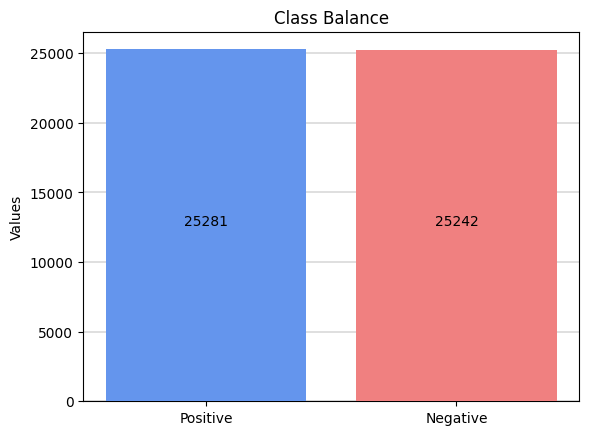

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=5000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 70% data train and 30% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 3445) (40418,)
(10105, 3445) (10105,)


In [8]:
y_train

39955    0
21831    1
4119     1
35999    0
19284    0
        ..
21003    1
33911    1
3894     0
14553    0
34860    1
Name: Label, Length: 40418, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [10]:
x_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [11]:
x_train.shape

(40418, 3445, 1)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model cnn-lstm
def hybrid_cnn_lstm(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input((x_train.shape[1], 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 3445, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 104s 78ms/step - accuracy: 0.6787 - loss: 0.5543 - val_accuracy: 0.8138 - val_loss: 0.3843
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 98s 77ms/step - accuracy: 0.7610 - loss: 0.4288 - val_accuracy: 0.8252 - val_loss: 0.3659
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7754 - loss: 0.4031 - val_accuracy: 0.8321 - val_loss: 0.3538
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7905 - loss: 0.3788 - val_accuracy: 0.8333 - val_loss: 0.3456
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7986 - loss: 0.3581 - val_accuracy: 0.8298 - val_loss: 0.3485
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.8109 - loss: 0.3384 - val_accuracy: 0.8314 - val_loss: 0.3569
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.8170 - loss: 0.3201 - val_accuracy: 0.8320 - val_loss: 0.3692


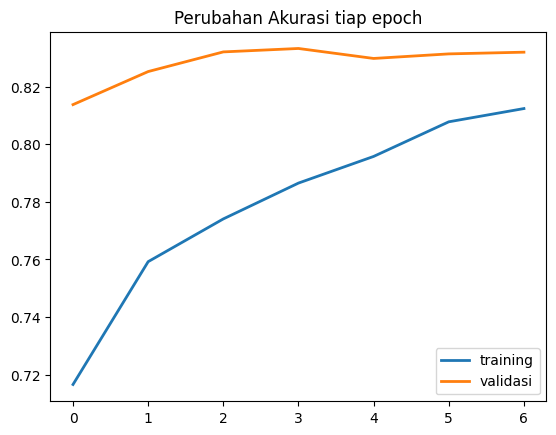

316/316 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.839687  0.823171  0.831347      5084
           1   0.824448  0.840868  0.832577      5021

    accuracy                       0.831964     10105
   macro avg   0.832068  0.832020  0.831962     10105
weighted avg   0.832115  0.831964  0.831958     10105



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 101s 78ms/step - accuracy: 0.6925 - loss: 0.5350 - val_accuracy: 0.8165 - val_loss: 0.3749
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 140s 77ms/step - accuracy: 0.7622 - loss: 0.4226 - val_accuracy: 0.8311 - val_loss: 0.3536
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7839 - loss: 0.3860 - val_accuracy: 0.8399 - val_loss: 0.3404
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7960 - loss: 0.3637 - val_accuracy: 0.8355 - val_loss: 0.3437
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 143s 78ms/step - accuracy: 0.8121 - loss: 0.3352 - val_accuracy: 0.8299 - val_loss: 0.3469
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 77ms/step - accuracy: 0.8212 - loss: 0.3195 - val_accuracy: 0.8321 - val_loss: 0.3567


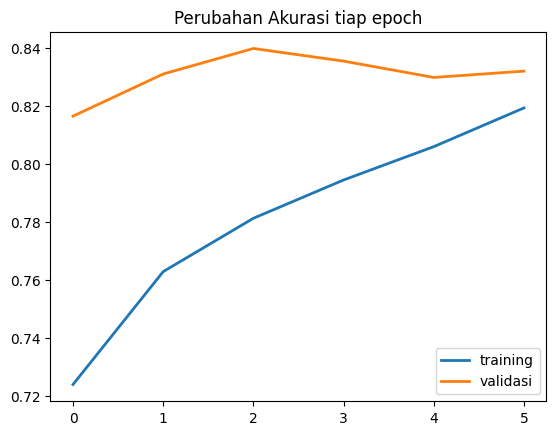

316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.848099  0.811566  0.829430      5084
           1   0.817176  0.852818  0.834617      5021

    accuracy                       0.832063     10105
   macro avg   0.832637  0.832192  0.832023     10105
weighted avg   0.832734  0.832063  0.832007     10105



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 100s 78ms/step - accuracy: 0.6861 - loss: 0.5322 - val_accuracy: 0.8166 - val_loss: 0.4018
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 77ms/step - accuracy: 0.7666 - loss: 0.4212 - val_accuracy: 0.8334 - val_loss: 0.3520
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 77ms/step - accuracy: 0.7891 - loss: 0.3791 - val_accuracy: 0.8352 - val_loss: 0.3469
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.8036 - loss: 0.3509 - val_accuracy: 0.8362 - val_loss: 0.3391
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 99s 78ms/step - accuracy: 0.8187 - loss: 0.3230 - val_accuracy: 0.8340 - val_loss: 0.3600
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 141s 78ms/step - accuracy: 0.8272 - loss: 0.3014 - val_accuracy: 0.8246 - val_loss: 0.3627
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 142s 78ms/step - accuracy: 0.8377 - loss: 0.2848 - val_accuracy: 0.8312 - val_loss: 0.3817


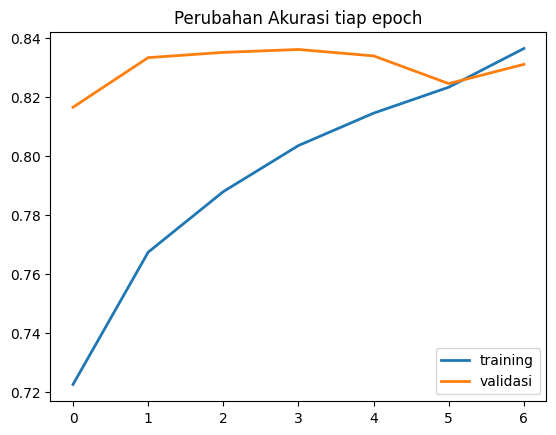

316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.842041  0.817860  0.829774      5084
           1   0.820786  0.844652  0.832548      5021

    accuracy                       0.831173     10105
   macro avg   0.831414  0.831256  0.831161     10105
weighted avg   0.831480  0.831173  0.831153     10105



In [14]:
result = []
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8317334652812138
Average Precision : 0.8208032260694771
Average Recall    : 0.8461129920998474
Average F1-Score  : 0.8332473352727567
